# Local Multimodal pipeline with OpenVINO

[OpenVINO™](https://github.com/openvinotoolkit/openvino) is an open-source toolkit for optimizing and deploying AI inference. The OpenVINO™ Runtime supports various hardware [devices](https://github.com/openvinotoolkit/openvino?tab=readme-ov-file#supported-hardware-matrix) including x86 and ARM CPUs, and Intel GPUs. It can help to boost deep learning performance in Computer Vision, Automatic Speech Recognition, Natural Language Processing and other common tasks.

Hugging Face multimodal model can be supported by OpenVINO through ``OpenVINOMultiModal`` class.

In [ ]:
%pip install llama-index-multi-modal-llms-openvino -q

In [ ]:
%pip install llama-index llama-index-readers-file -q

### Export and compress multimodal model

It is possible to [export your model](https://github.com/huggingface/optimum-intel?tab=readme-ov-file#export) to the OpenVINO IR format with the CLI, and load the model from local folder.

In [ ]:
from pathlib import Path

model_id = "llava-hf/llava-v1.6-mistral-7b-hf"
model_path = Path(model_id.split("/")[-1]) / "FP16"

if not model_path.exists():
    !optimum-cli export openvino --model {model_id} --weight-format fp16 {model_path}

In [ ]:
import shutil
import nncf
import openvino as ov
import gc

core = ov.Core()

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_SYM,
    "group_size": 64,
    "ratio": 0.6,
}

compressed_model_path = model_path.parent / "INT4"
if not compressed_model_path.exists():
    ov_model = core.read_model(model_path / "openvino_language_model.xml")
    compressed_ov_model = nncf.compress_weights(ov_model, **compression_config)
    ov.save_model(
        compressed_ov_model,
        compressed_model_path / "openvino_language_model.xml",
    )
    del compressed_ov_model
    del ov_model
    gc.collect()
    for file_name in model_path.glob("*"):
        if file_name.name in [
            "openvino_language_model.xml",
            "openvino_language_model.bin",
        ]:
            continue
        shutil.copy(file_name, compressed_model_path)

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 2% (1 / 225)                │ 0% (0 / 224)                           │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 98% (224 / 225)             │ 100% (224 / 224)                       │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

### Prepare the input data

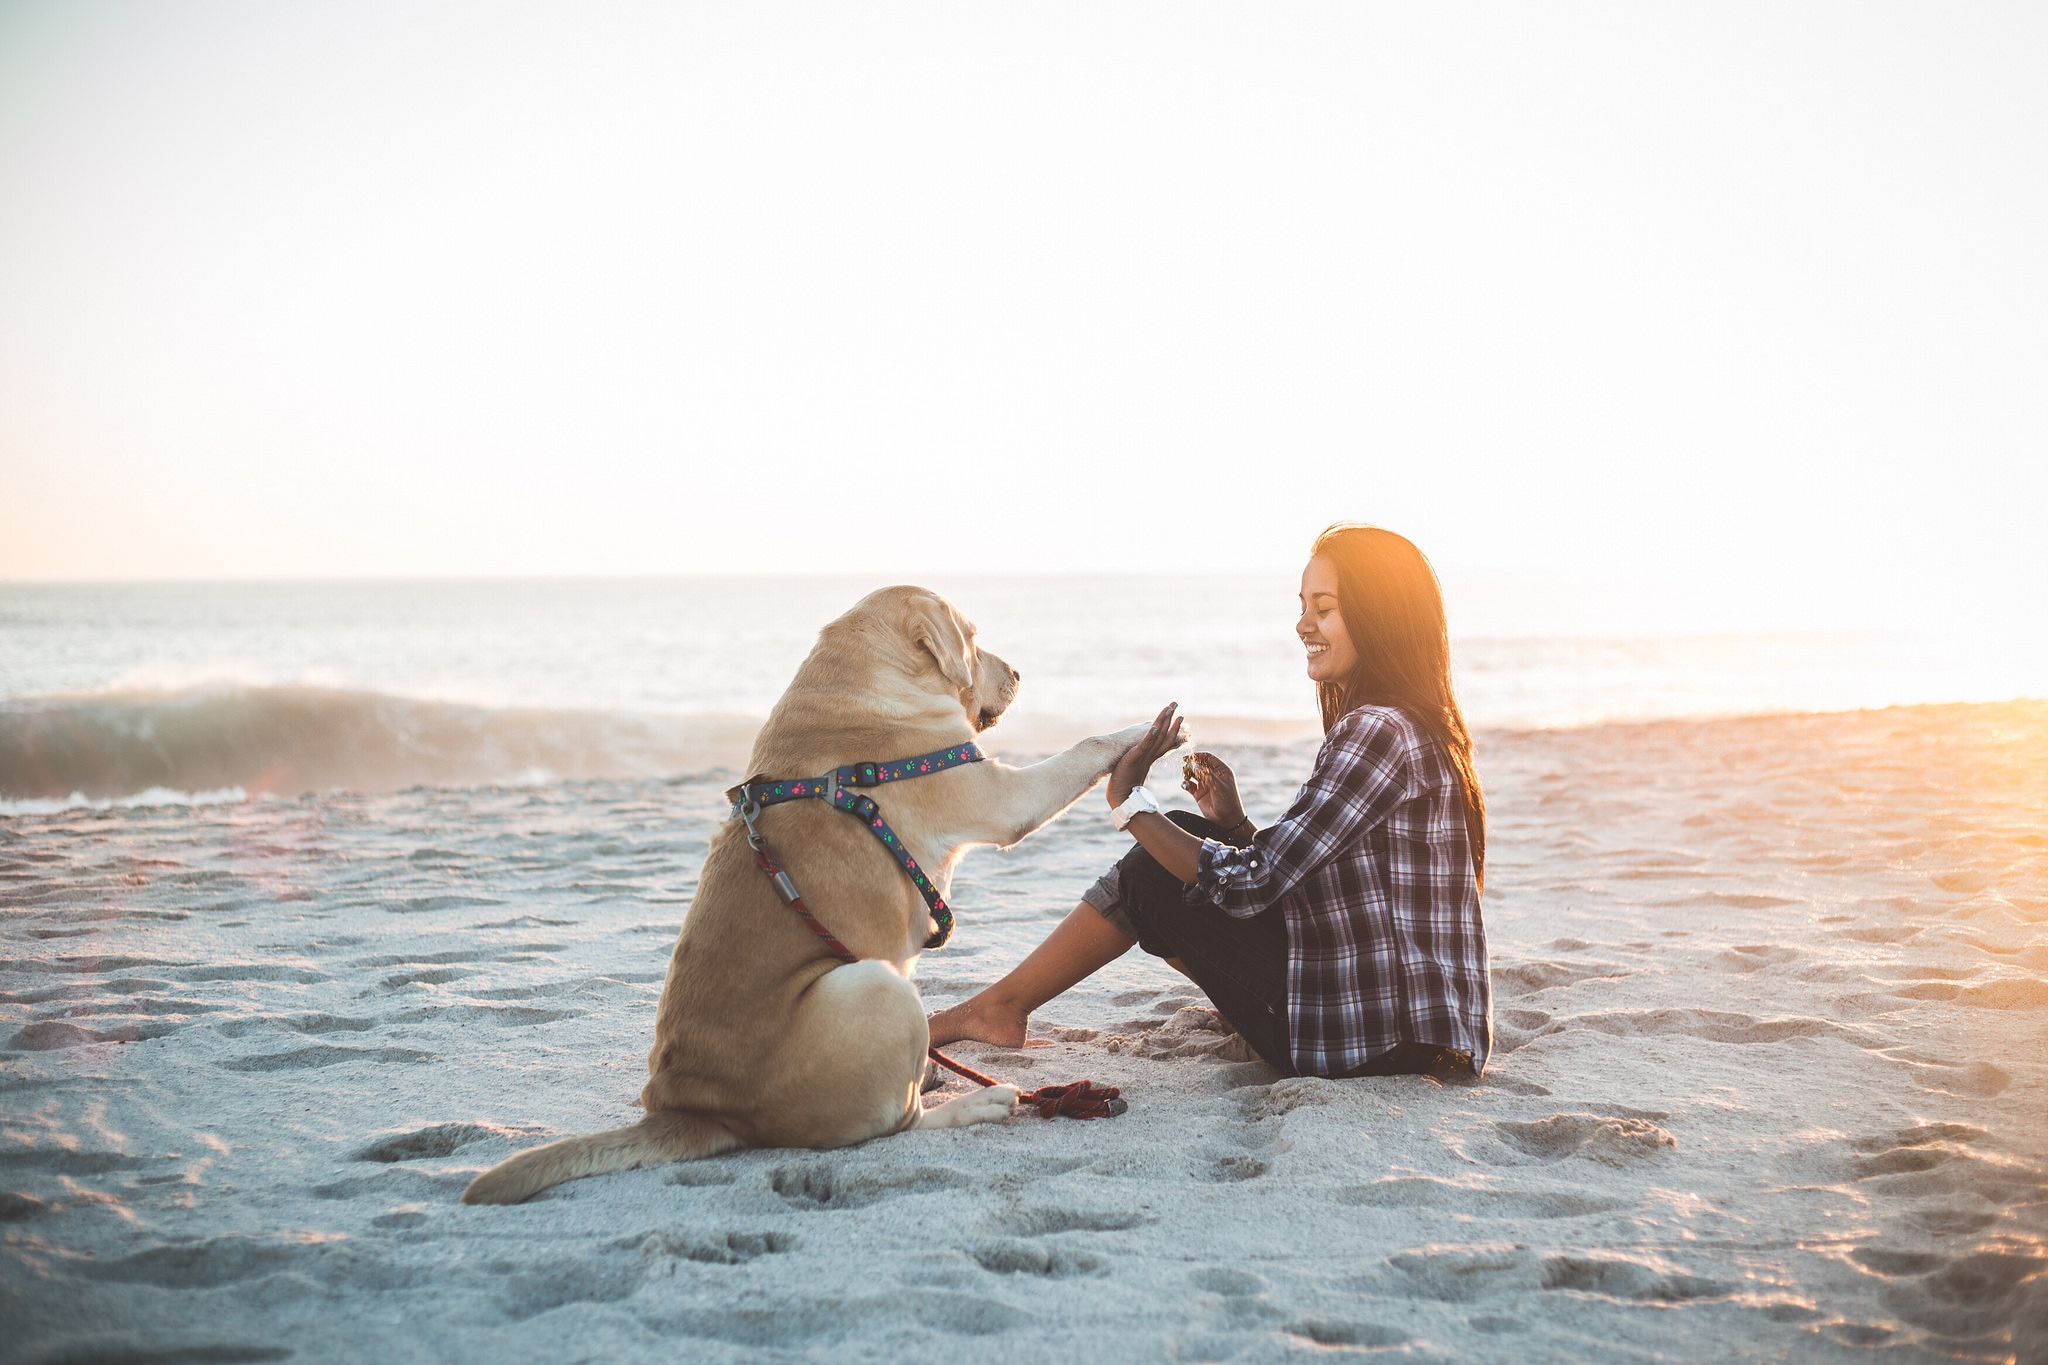

In [ ]:
import os

os.makedirs("./input_images", exist_ok=True)

url = "https://dashscope.oss-cn-beijing.aliyuncs.com/images/dog_and_girl.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

image

In [ ]:
from llama_index.multi_modal_llms.openvino import OpenVINOMultiModal
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(
    "llava-v1.6-mistral-7b-hf/INT4", trust_remote_code=True
)


def messages_to_prompt(messages, image_documents):
    """
    Prepares the input messages and images.
    """
    conversation = [{"type": "text", "text": messages[0].content}]
    images = []
    for img_doc in image_documents:
        images.append(img_doc)
        conversation.append({"type": "image"})
    messages = [
        {"role": "user", "content": conversation}
    ]  # Wrap conversation in a user role

    print(messages)

    # Apply a chat template to format the message with the processor
    text_prompt = processor.apply_chat_template(
        messages, add_generation_prompt=True
    )

    # Prepare the model inputs (text + images) and convert to tensor
    inputs = processor(text=text_prompt, images=images, return_tensors="pt")
    return inputs

### Model Loading

Models can be loaded by specifying the model parameters using the `OpenVINOMultiModal` method.

If you have an Intel GPU, you can specify `device_map="gpu"` to run inference on it.

In [ ]:
vlm = OpenVINOMultiModal(
    model_id_or_path="llava-v1.6-mistral-7b-hf/INT4",
    device="cpu",
    messages_to_prompt=messages_to_prompt,
    generate_kwargs={"do_sample": False},
)

### Inference with local OpenVINO model

In [ ]:
response = vlm.complete("Describe the images", image_documents=[image])
print(response.text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'role': 'user', 'content': [{'type': 'text', 'text': 'Describe the images'}, {'type': 'image'}]}]
The image shows a person and a dog on a sandy beach. The person is sitting on the sand, facing the camera, and appears to be smiling. They are wearing a plaid shirt and dark pants. The dog is standing next to the person, looking up at the person's hand, which is extended towards the dog. The dog is wearing a harness and has a collar with a tag. The background features the ocean with waves, and the sky is clear with a warm glow, suggesting either sunrise or sunset. The overall atmosphere of the image is peaceful and joyful, capturing a moment of interaction between the person and the dog. 


### Streaming

In [ ]:
response = vlm.stream_complete("Describe the images", image_documents=[image])
for r in response:
    print(r.delta, end="")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'role': 'user', 'content': [{'type': 'text', 'text': 'Describe the images'}, {'type': 'image'}]}]
The image shows a person and a dog on a sandy beach. The person is sitting on the sand, facing the camera, and appears to be smiling. They are wearing a plaid shirt and dark pants. The dog is standing next to the person, looking up at the person's hand, which is extended towards the dog. The dog is wearing a harness and has a collar with a tag. The background features the ocean with waves, and the sky is clear with a warm glow, suggesting either sunrise or sunset. The overall atmosphere of the image is peaceful and joyful, capturing a moment of interaction between the person and the dog. 